# Recurrent Neural Networks 

_The only thing we know about the future is that it will be different_ - Peter Drucker

Concepts:
- Elman RNN
- Linear Dynamic Factor Models
  
References
- Philipp Krahenbuhl, 2020, "CS395T Deep Learning course materials", retrieved from http://www.philkr.net/dl_class/material
- https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_dfm_coincident.html


In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import gc
import statsmodels.api as sm
import torch
import torch.nn as nn
import torchinfo
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from finds.structured import BusDay
from finds.readers import Alfred
from secret import credentials
import warnings

In [2]:
# %matplotlib qt
VERBOSE = 0
if not VERBOSE:  # Suppress FutureWarning messages
    warnings.simplefilter(action='ignore', category=FutureWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Max number of hidden states (RNN) or factors (Dynamic Model)
K = 2

In [4]:
# number of out-of-sample forecasts to predict
nforecast = 3

In [5]:
# train-test split date
split_date = '2021-12-01'

In [6]:
# Load time series from FRED
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=VERBOSE)
vspans = alf.date_spans('USREC')  # recession periods

In [7]:
# CPI for U.S. City Average: Monthly, Seasonally Adjusted
# https://fred.stlouisfed.org/release/tables?rid=10&eid=34483
# 'CUSR0000SEEA'
series_ids = ['CPIFABSL', 'CPIHOSSL', 'CPIAPPSL', 'CPITRNSL', 'CPIMEDSL', 'CPIOGSSL']
df = pd.concat([alf(s, log=1, diff=1) for s in series_ids], axis=1)\
       .dropna()\
       .sort_index()
df.index = BusDay.to_datetime(df.index)
df.index.freq = 'ME'     # set index to datetime type and freq = 'M'

In [8]:
names = [s[s.find(':')+2:s.find(' in ')] for s in alf.header(series_ids)]
names

['Food and Beverages',
 'Housing',
 'Apparel',
 'Transportation',
 'Medical Care',
 'Other Goods and Services']

In [9]:
# Standardize the data data
scaler = StandardScaler().fit(df)
scaled_data = DataFrame(scaler.transform(df), columns=names, index=df.index)
scaled_data

,Food and Beverages,Housing,Apparel,Transportation,Medical Care,Other Goods and Services
date,,,,,,
1967-02-28,-1.514294,-1.123374,0.528419,0.262158,-0.260945,-1.020565
1967-03-31,-0.803761,-1.123374,0.117546,-0.270473,-0.265522,-0.290026
1967-04-30,-1.516345,-0.064928,0.523552,0.258920,0.977131,-1.020565
1967-05-31,-0.803761,-0.068382,0.115127,-0.006978,-0.279054,-0.292134
1967-06-30,1.327849,-1.123374,0.518742,-0.270473,0.950357,-0.294231
...,...,...,...,...,...,...
2023-12-31,-0.305673,-0.150090,-0.300364,-0.226813,-0.199913,-0.950240
2024-01-31,0.136279,0.874513,-1.728819,-0.823810,0.045640,0.340696
2024-02-29,-0.763532,0.154003,0.841913,0.932892,-1.610667,-1.786460


## Elman RNN

Applies a multi-layer Elman RNN with tanh (or ReLU) non-linearity to an input sequence.

For each element in the input sequence, each layer computes the following function:

$$h_t = \tanh(x_t~W_{ih}^T​ + b_{ih} ​+ h_{t−1} ​W_{hh}^T ​+ b _{hh}​)$$

where 

- $h_t$​ is the hidden state at time $t$, 
- $x_t$​ is the input at time $t$,
- $h_{t−1}$​ is the hidden state of the previous layer at time $t-1$ or the initial hidden state at time 0, and
- $b$'s and $W$'s are the learnable bias and weights


In [10]:
class Elman(nn.Module):
    def __init__(self, n_features, hidden_size, dropout, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = n_features
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.RNN(input_size=n_features,
                          hidden_size=hidden_size,
                          num_layers=num_layers)
        self.o2o = nn.Linear(hidden_size, n_features)

    def forward(self, x, hidden):
        x = self.dropout(x)     # drop out input layer
        output, hidden = self.rnn(x, hidden)
        output = self.o2o(output[-1:, :])
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.num_layers, self.hidden_size)

In [11]:
# Create input data for RNN
ntrain = sum(scaled_data.index < split_date)
ntest = len(scaled_data.index) - ntrain - 1
n_features = scaled_data.shape[1]
data = scaled_data.values

### Learning rate

learning rate schedulimg


In [12]:
# Train model
num_layers = 1
dropout = 0.0
lr = 0.01         # starting learning rate
step_size = 100   # number of steps per learning rate
num_lr = 3        # number of learning rate periods
num_epochs = step_size * num_lr

train_loss = {}
hidden_states = {}
for hidden_size in range(1, K+1):
    torch.manual_seed(0)
    model = Elman(n_features=n_features,
                  hidden_size=hidden_size,
                  dropout=dropout,
                  num_layers=num_layers).to(device)
    print(model)
    torchinfo.summary(model)

    # Set optimizer and learning rate scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=step_size,
                                                gamma=0.1)
    loss_function = nn.MSELoss()
    train_loss[hidden_size] = []
    for epoch in tqdm(range(num_epochs)):   # Run training loop per epoch
        model.train()
        model.zero_grad()
        hidden = model.init_hidden().to(device)
        loss = torch.FloatTensor([0]).to(device)
        for i in range(ntrain):
            x = torch.FloatTensor(data[[i], :]).to(device)
            y = torch.FloatTensor(data[[i+1], :]).to(device)
            output, hidden = model(x, hidden)
            l = loss_function(output, y)
            loss += l
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        model.eval()
        train_loss[hidden_size].append(float(loss)/ntrain)
        #if VERBOSE:
        #    print(epoch, train_loss[hidden_size][-1], scheduler.get_last_lr())

    # collect predictions and hidden states, and compute mse
    with torch.no_grad():    # reduce memory consumption for eval
        loss_function = nn.MSELoss()
        hidden = model.init_hidden().to(device)
        hidden_states[hidden_size] = [hidden.cpu().numpy().flatten()]
        y_pred = [np.zeros(n_features)]
        for i in range(ntrain + ntest):
            x = torch.FloatTensor(data[[i], :]).to(device)
            y = torch.FloatTensor(data[[i+1], :]).to(device)
            output, hidden = model(x, hidden)
            hidden_states[hidden_size].append(hidden.cpu().numpy().flatten())
            y_pred.append(output.cpu().numpy().flatten())

        # k-step ahead forecast at end of period
        for i in range(nforecast):
            x = y
            y, hidden = model(x, hidden)
            y_pred.append(y.cpu().numpy().flatten())
        print(f"train MSE (hidden={hidden_size}):",
              mean_squared_error(data[1:ntrain+1, :], y_pred[1:ntrain+1]))
        print(f"test MSE (hidden={hidden_size}):",
              mean_squared_error(data[ntrain+1:ntrain+ntest+1, :],
                                 y_pred[ntrain+1:ntrain+ntest+1]))



Elman(
  (dropout): Dropout(p=0.0, inplace=False)
  (rnn): RNN(6, 1)
  (o2o): Linear(in_features=1, out_features=6, bias=True)
)


/home/terence/env3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 300/300 [01:32<00:00,  3.23it/s]


train MSE (hidden=1): 0.8109380710349426
test MSE (hidden=1): 0.8741724611011269
Elman(
  (dropout): Dropout(p=0.0, inplace=False)
  (rnn): RNN(6, 2)
  (o2o): Linear(in_features=2, out_features=6, bias=True)
)


100%|██████████| 300/300 [01:30<00:00,  3.31it/s]

train MSE (hidden=2): 0.753971276651208
test MSE (hidden=2): 0.7898786960734855


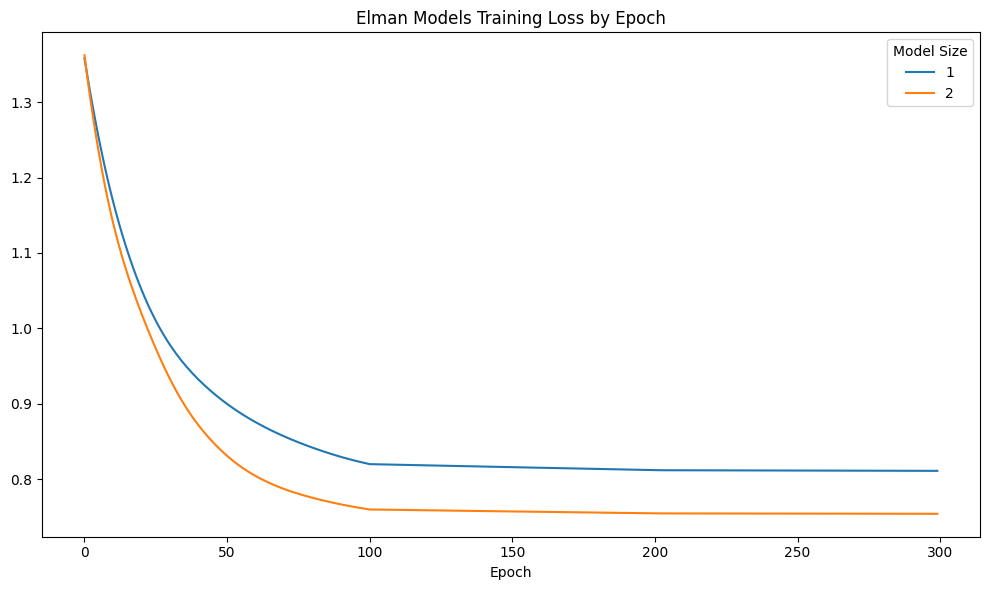

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
DataFrame(train_loss).plot(ax=ax)
ax.set_title(f"Elman Models Training Loss by Epoch")
ax.set_xlabel('Epoch')
ax.legend(title='Model Size')
plt.tight_layout()




In [14]:
# Show forecasts of last model
pred = scaler.inverse_transform(y_pred)      # undo standardization
t = [scaled_data.index[-1] + pd.DateOffset(months=i) for i in range(nforecast + 1)]
forecasts = DataFrame(np.vstack((np.zeros(n_features), pred[-nforecast:])),
                      index=pd.PeriodIndex(t, freq='M'), columns=scaled_data.columns)
print("Monthly forecasts from RNN Model")
forecasts



Monthly forecasts from RNN Model


,Food and Beverages,Housing,Apparel,Transportation,Medical Care,Other Goods and Services
2024-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-05,0.001705,0.002635,0.001403,0.002468,0.004944,0.004344
2024-06,0.002111,0.002760,0.001257,0.002412,0.004646,0.004142
2024-07,0.002322,0.002791,0.001137,0.002353,0.004429,0.003991


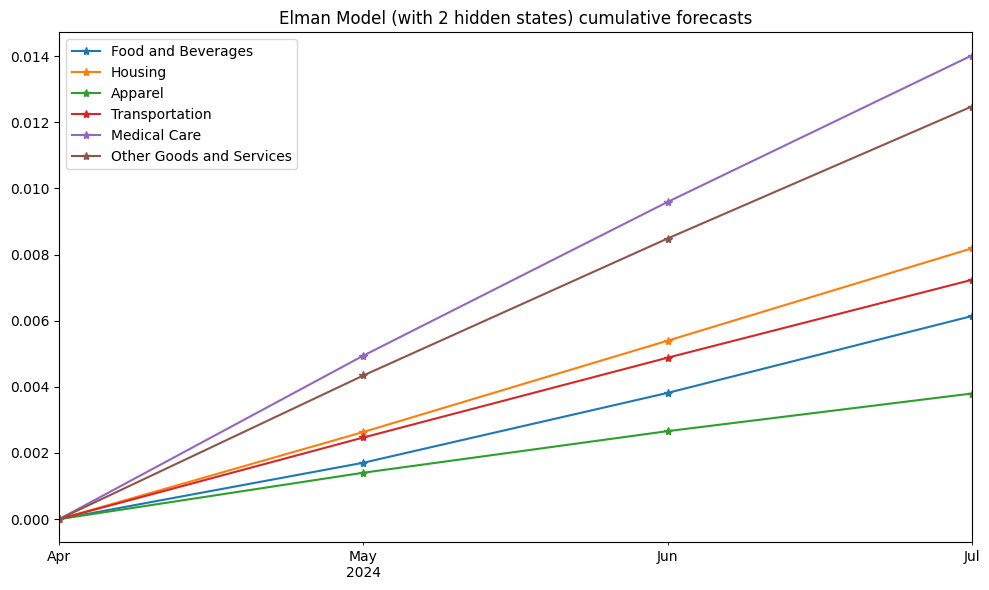

In [15]:
# Plot forecasts
fig, ax = plt.subplots(figsize=(10, 6))
forecasts.cumsum().plot(ax=ax, marker='*')
ax.set_title(f"Elman Model (with {K} hidden states) cumulative forecasts")
plt.tight_layout()


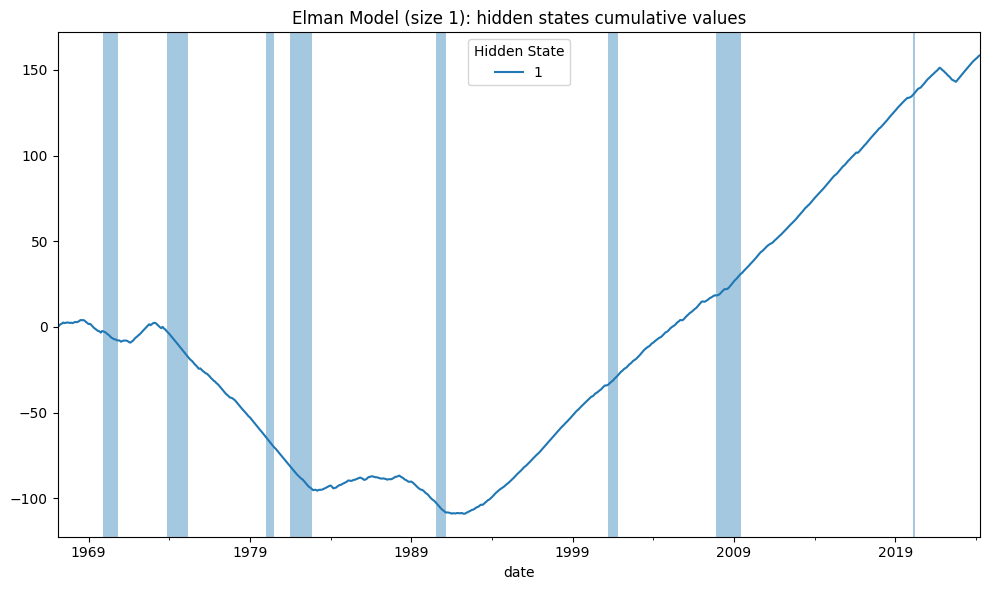

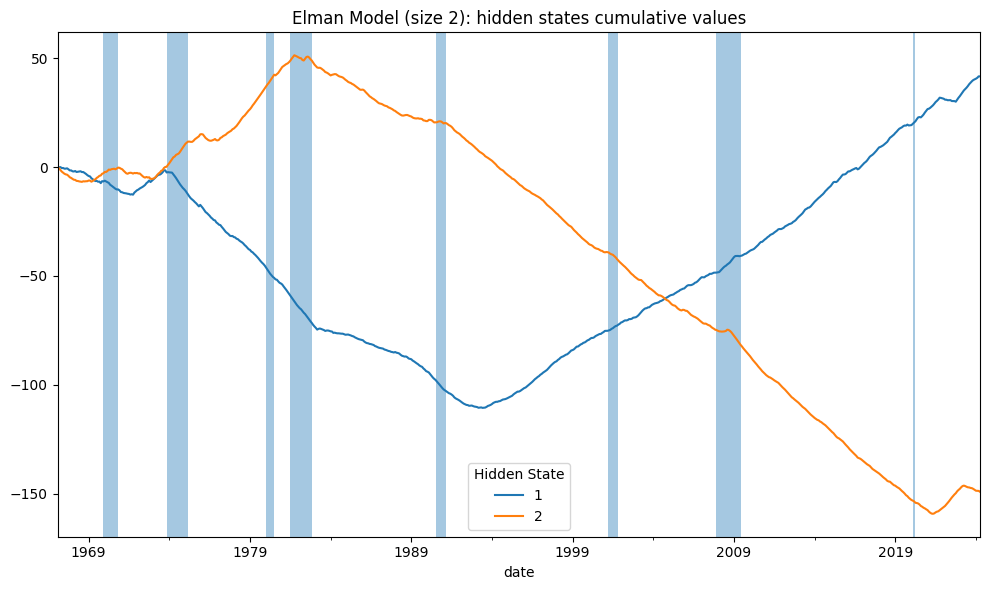

In [16]:

# Plot RNN hidden states values
for k, hidden in hidden_states.items():
    fig, ax = plt.subplots(figsize=(10, 6))
    hidden = DataFrame(np.array(hidden), index=scaled_data.index,
                       columns=[f"{i+1}" for i in range(k)])
    hidden.cumsum().plot(ax=ax, style='-')
    for a,b in vspans:
        if a >= min(hidden.index):
            ax.axvspan(a, min(b, max(hidden.index)), alpha=0.4)
    ax.legend(title='Hidden State')
    ax.set_title(f"Elman Model (size {k}): hidden states cumulative values")
    plt.tight_layout()


## Dynamic Factor Models

The basic model is:

$$y_t = \Lambda f_t + \epsilon_t$$

$$f_t = A_1 f_{t-1} + \cdots + A_2 f_{t-2} + u_t$$

where:
- $y_t$ is observed data at time t
- $\epsilon_t$ is idiosyncratic disturbance at time t
- $f_t$ is the unobserved factor at time t
- $u_t \sim N(0, Q)$ is the factor disturbance at time t
- $\Lambda$ is referred to as the matrix of factor loadings
- $A_i$ are matrices of autoregression coefficients

The `DynamicFactorMQ` model in `statsmodels` package
uses the EM algorithm for parameter fitting, and so can accommodate a
large number of observed variables. Specifications of the model can include
any collection of blocks of factors, including different factor
autoregression orders, and AR(1) processes for
idiosyncratic disturbances. It can incorporate monthly/quarterly mixed
frequency data, which allows for Nowcasting models.



In [17]:

# Fit ar lags with best BIC
dynamic_factors = dict()
models = {}
K = 2
for ar in range(1, 5):
    mod = sm.tsa.DynamicFactorMQ(endog=scaled_data,
                                 factors=1,                # num factor blocks
                                 factor_multiplicities=K,  # num factors in block
                                 factor_orders=ar,         # order of factor VAR
                                 idiosyncratic_ar1=True)
    fitted = mod.fit(disp=20 * bool(VERBOSE),
                     maxiter=1000,
                     full_output=True)
    models[ar] = dict(bic=fitted.bic, 
                      mse=fitted.mse, 
                      summary=fitted.summary().tables[0],
                      predict=fitted.predict(),
                      forecast=fitted.forecast(nforecast),
                      params=len(fitted.param_names))
    dynamic_factors[ar] = DataFrame(fitted.factors.filtered)
    dynamic_factors[ar].columns = np.arange(1, K+1)
    print(DataFrame(dict(bic=fitted.bic,
                         mse=fitted.mse,
                         parameters=len(fitted.param_names)),
                    index=[ar]))
    del fitted
    del mod
    gc.collect()



            bic       mse  parameters
1  10336.076878  4.277298          31
            bic       mse  parameters
2  10357.094374  4.273679          35
            bic       mse  parameters
3  10360.490386  4.238931          39
            bic       mse  parameters
4  10377.211151  4.233325          43


In [18]:
# AR model with best bic
best, model = min(models.items(), key=lambda item: item[1]['bic'])
mse = mean_squared_error(scaled_data, model['predict'])
print('Best lag:', best, '  bic:', model['bic'])
print(model['summary'])


Best lag: 1   bic: 10336.076878452934
                                   Dynamic Factor Results                                   
Dep. Variable:     "Food and Beverages", and 5 more   No. Observations:                  687
Model:                         Dynamic Factor Model   Log Likelihood               -5066.787
                            + 2 factors in 1 blocks   AIC                          10195.575
                              + AR(1) idiosyncratic   BIC                          10336.077
Date:                              Mon, 27 May 2024   HQIC                         10249.934
Time:                                      14:39:53   EM Iterations                      221
Sample:                                  02-28-1967                                         
                                       - 04-30-2024                                         
Covariance Type:                       Not computed                                         


Dynamic Factor Model Train MSE: 0.7115009239837685
Dynamic Factor Model Test MSE: 0.7963197085903823
Number of parameters: 31


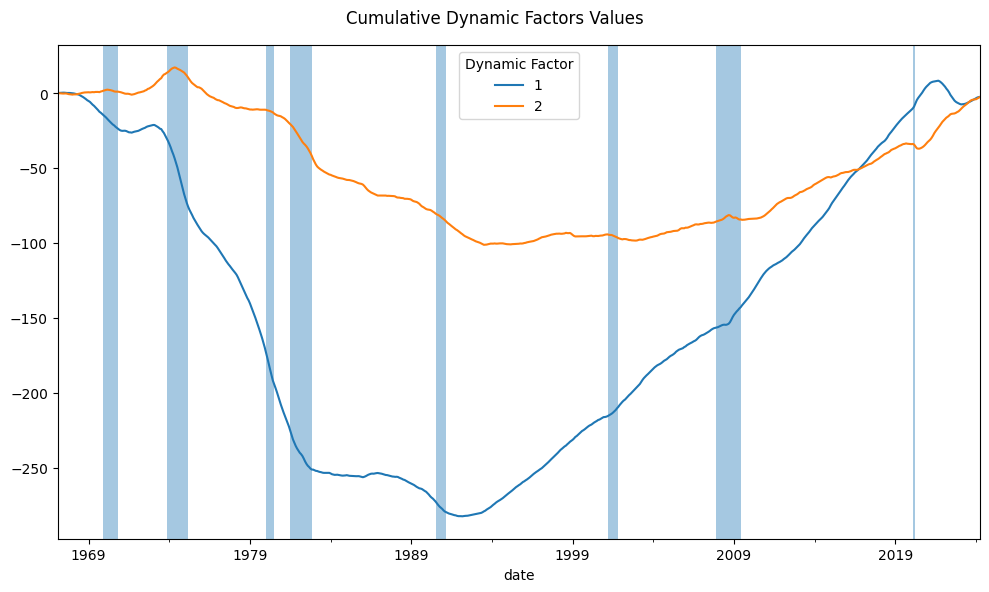

In [19]:
# Plot dynamic factors
dynamic_factor = dynamic_factors[best]
fig, ax = plt.subplots(figsize=(10, 6))
dynamic_factor.cumsum().plot(ax=ax, style='-')
ax.legend(title='Dynamic Factor')
for a,b in vspans:
    if a >= min(dynamic_factor.index):
        ax.axvspan(a, min(b, max(dynamic_factor.index)), alpha=0.4)
plt.suptitle(f"Cumulative Dynamic Factors Values")
plt.tight_layout()


# Show forecasts of selected series
print('Dynamic Factor Model Train MSE:', 
      mean_squared_error(scaled_data.iloc[1:ntrain+1],
                         model['predict'].iloc[1:ntrain+1]))
print('Dynamic Factor Model Test MSE:', 
      mean_squared_error(scaled_data.iloc[ntrain+1:],
                         model['predict'].iloc[ntrain+1:]))
print('Number of parameters:', model['params'])


In [20]:
model_out = scaler.inverse_transform(model['forecast'].iloc[:nforecast])
model_out = DataFrame(np.vstack((np.zeros(n_features), model_out)),
                      index=pd.PeriodIndex(t, freq='M'), columns=scaled_data.columns)
print("Monthly forecasts from Dynamic Factor Model")
model_out


Monthly forecasts from Dynamic Factor Model


,Food and Beverages,Housing,Apparel,Transportation,Medical Care,Other Goods and Services
2024-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-05,0.002610,0.002940,0.003380,0.005612,0.003679,0.003070
2024-06,0.003168,0.003195,0.002135,0.005062,0.003635,0.003211
2024-07,0.003294,0.003290,0.001925,0.004764,0.003685,0.003279


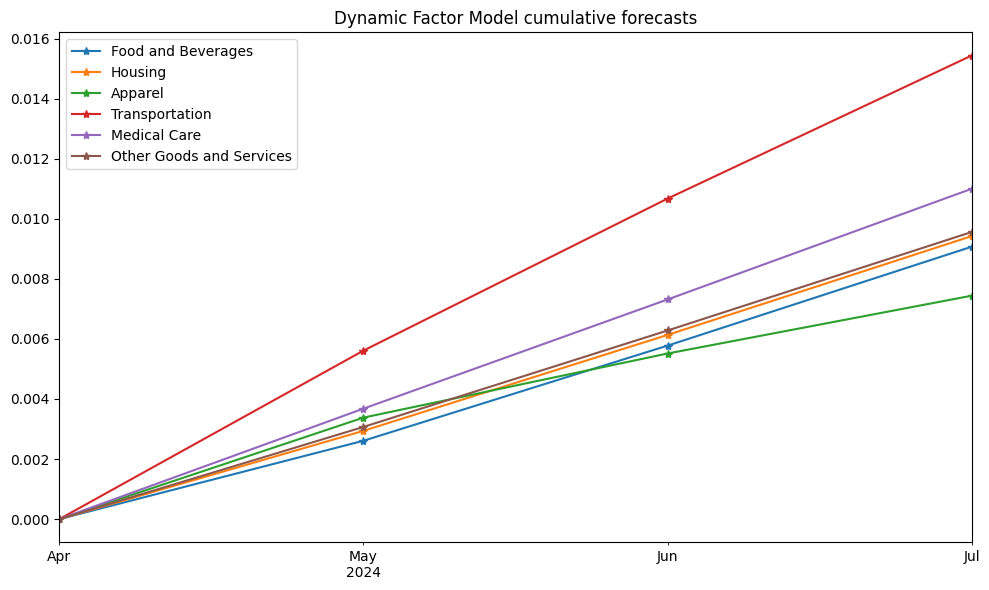

In [21]:
# Plot forecasts
fig, ax = plt.subplots(figsize=(10, 6))
model_out.cumsum().plot(ax=ax, marker='*')
ax.set_title(f"Dynamic Factor Model cumulative forecasts")
plt.tight_layout()

In [22]:
# RNN hidden state values explained by dynamic factors
rsq = dict()
for k, hidden_state in enumerate(np.array(hidden_states[2]).T):
    rsq[k+1] = sm.OLS(hidden_state, sm.add_constant(dynamic_factor).fillna(0))\
                 .fit()
print('Proportion of variance of RNN hidden state values '
      'explained by dynamic factors:',
      np.mean([r.rsquared for r in rsq.values()]).round(4))
DataFrame({k: [r.rsquared, r.f_pvalue] for k, r in rsq.items()},
          index=['R-square', 'pvalue'])\
          .rename_axis(columns='Hidden State')\
          .round(4)

Proportion of variance of RNN hidden state values explained by dynamic factors: 0.7325


Hidden State,1,2
R-square,0.7409,0.724
pvalue,0.0000,0.000
